# Embedding Tutorial
- [Introduction to Text Embeddings (Outdated codes due to openai version)](https://www.datacamp.com/tutorial/introduction-to-text-embeddings-with-the-open-ai-api)

## Embedding Models
- [tiktoken - Byte pair encoding](https://github.com/openai/tiktoken/tree/main?tab=readme-ov-file)
- [Sentence Transformer](https://www.sbert.net/examples/applications/computing-embeddings/README.html)
- [Openai Embedding Model](https://platform.openai.com/docs/guides/embeddings)

In [48]:
import os
import pandas as pd
from openai import OpenAI
from scipy.spatial import distance
import plotly.express as px
from sklearn.cluster import KMeans
from umap import UMAP
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
from dotenv import load_dotenv
import tiktoken
from sentence_transformers import SentenceTransformer
from google import genai
from google.genai import types


load_dotenv(".env")
# Display all rows
pd.set_option('display.max_rows', None)
# Display all columns
pd.set_option('display.max_columns', None)
# Set display option to show full content in each column
# pd.set_option('display.max_colwidth', None)

In [18]:
# data_URL =  "https://raw.githubusercontent.com/keitazoumana/Experimentation-Data/main/Musical_instruments_reviews.csv"
data_file_path = "data/sentimentdataset.csv"


df = pd.read_csv(data_file_path)
display(df.head())
print(df["Sentiment"].unique().tolist())
df = df[['Text', 'Sentiment']]
print("Data shape: {}".format(df.shape))
# df = df.sample(100)
df.reset_index(drop=True, inplace=True)
df.to_pickle('data/sentiment_raw.pkl')
display(df.head())

,Unnamed: 0.1,Unnamed: 0,Text,Sentiment,Timestamp,User,Platform,Hashtags,Retweets,Likes,Country,Year,Month,Day,Hour
0,0,0,Enjoying a beautiful day at the park! ...,Positive,2023-01-15 12:30:00,User123,Twitter,#Nature #Park,15.0,30.0,USA,2023,1,15,12
1,1,1,Traffic was terrible this morning. ...,Negative,2023-01-15 08:45:00,CommuterX,Twitter,#Traffic #Morning,5.0,10.0,Canada,2023,1,15,8
2,2,2,Just finished an amazing workout! 💪 ...,Positive,2023-01-15 15:45:00,FitnessFan,Instagram,#Fitness #Workout,20.0,40.0,USA,2023,1,15,15
3,3,3,Excited about the upcoming weekend getaway! ...,Positive,2023-01-15 18:20:00,AdventureX,Facebook,#Travel #Adventure,8.0,15.0,UK,2023,1,15,18
4,4,4,Trying out a new recipe for dinner tonight. ...,Neutral,2023-01-15 19:55:00,ChefCook,Instagram,#Cooking #Food,12.0,25.0,Australia,2023,1,15,19


[' Positive  ', ' Negative  ', ' Neutral   ', ' Anger        ', ' Fear         ', ' Sadness      ', ' Disgust      ', ' Happiness    ', ' Joy          ', ' Love         ', ' Amusement    ', ' Enjoyment    ', ' Admiration   ', ' Affection    ', ' Awe          ', ' Disappointed ', ' Surprise     ', ' Acceptance   ', ' Adoration    ', ' Anticipation ', ' Bitter       ', ' Calmness     ', ' Confusion    ', ' Excitement   ', ' Kind         ', ' Pride        ', ' Shame        ', ' Confusion ', ' Excitement ', ' Shame ', ' Elation       ', ' Euphoria      ', ' Contentment   ', ' Serenity      ', ' Gratitude     ', ' Hope          ', ' Empowerment   ', ' Compassion    ', ' Tenderness    ', ' Arousal       ', ' Enthusiasm    ', ' Fulfillment  ', ' Reverence     ', ' Compassion', ' Fulfillment   ', ' Reverence ', ' Elation   ', ' Despair         ', ' Grief           ', ' Loneliness      ', ' Jealousy        ', ' Resentment      ', ' Frustration     ', ' Boredom         ', ' Anxiety         ', ' 

,Text,Sentiment
0,Enjoying a beautiful day at the park! ...,Positive
1,Traffic was terrible this morning. ...,Negative
2,Just finished an amazing workout! 💪 ...,Positive
3,Excited about the upcoming weekend getaway! ...,Positive
4,Trying out a new recipe for dinner tonight. ...,Neutral


In [114]:
# Openai
client = OpenAI(
  api_key=os.environ['OPENAI_API_KEY'],  # this is also the default, it can be omitted
)
# Tiktoken
enc = tiktoken.get_encoding("o200k_base")

# Gemini
client = genai.Client(api_key=os.environ['GEMINI_API_KEY']) # 3072 dimension for gemini-embedding-exp-03-07 embedding model

# Sentence Transformer
model = SentenceTransformer("all-MiniLM-L6-v2") # 256 input seq length -> 384-dimensional dense output
print(model.max_seq_length) # By default, the provided methods use a limit of 256 word pieces, longer inputs will be truncated. 

256


In [19]:
# Check rate limits
def get_embedding_openai(text_to_embed):
    # Embed a line of text
    response = client.embeddings.create(
        model= "text-embedding-ada-002",
        input=[text_to_embed]
    )
    embedding = response["data"][0]["embedding"]
    return embedding
def get_embedding_gemini(text_to_embed):
    # Embed a line of text
    result = client.models.embed_content(
        model="gemini-embedding-exp-03-07",
        contents=text_to_embed,
        config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY") # config=types.EmbedContentConfig(output_dimensionality=10),
    )
    return result.embeddings[0].values

In [20]:
df = pd.read_pickle('data/sentiment_raw.pkl')
df = df.sample(100)
df.reset_index(drop=True, inplace=True)
df["tiktoken_embedding"] = df["Text"].astype(str).apply(lambda x: enc.encode(x))
# df["ada_embedding"] = df["Text"].astype(str).apply(get_embedding_openai)
# df["gemini_embedding"] = df["Text"].astype(str).apply(get_embedding_gemini)
df["st_embedding"] = df["Text"].astype(str).apply(lambda x: model.encode(x))

# Get token counts
df["tiktoken_count"] = df["tiktoken_embedding"].apply(lambda x: len(x))
# df["ada_count"] = df["ada_embedding"].apply(lambda x: len(x))
# df["gemini_count"] = df["gemini_embedding"].apply(lambda x: len(x))
df["st_count"] = df["st_embedding"].apply(lambda x: len(x))
df["word_count"] = df["Text"].apply(lambda x: len(x.split()))

embedding_file_name = 'data/sentiment_embeddings.pkl'
df.to_pickle(embedding_file_name)
df = pd.read_pickle(embedding_file_name)
print("Number of records", len(df))
df.head()

Number of records 100


,Text,Sentiment,tiktoken_embedding,st_embedding,tiktoken_count,st_count,word_count
0,Trying out a new dessert recipe. ...,Positive,"[88976, 842, 261, 620, 47296, 14420, 13, 699]","[-0.014330666, -0.049130578, 0.0030075375, 0.0...",8,384,6
1,"Playfully dancing in the rain of laughter, a ...",Playful,"[9103, 5203, 38157, 306, 290, 13873, 328, 6734...","[0.015664198, -0.0048338617, 0.05227115, 0.013...",26,384,18
2,"Exploring the ancient ruins of Angkor Wat, eac...",Exploration,"[24704, 7443, 290, 21574, 76738, 328, 5775, 23...","[0.018491017, 0.054280628, 0.06413508, 0.05055...",20,384,14
3,"Overwhelmed by the cacophony of expectations,...",Overwhelmed,"[7931, 163185, 3217, 656, 290, 80188, 6502, 44...","[0.0034730374, 0.038468692, 0.030071173, 0.033...",26,384,18
4,Surrounded by the vibrant colors of a flower g...,Nature's Beauty,"[14477, 62633, 656, 290, 35180, 10803, 328, 26...","[0.017445965, 0.07143598, 0.0415588, 0.0294761...",30,384,22


# Analysis

In [130]:
embedding_file_name = 'data/sentiment_embeddings.pkl'
df = pd.read_pickle(embedding_file_name)
print("Number of records", len(df))
display(df.head())

embedding_file_name = 'data/sentiment_embeddings.pkl'

Number of records 100


,Text,Sentiment,tiktoken_embedding,st_embedding,tiktoken_count,st_count,word_count,kmeans
0,Trying out a new dessert recipe. ...,Positive,"[88976, 842, 261, 620, 47296, 14420, 13, 699]","[-0.014330666, -0.049130578, 0.0030075375, 0.0...",8,384,6,0
1,"Playfully dancing in the rain of laughter, a ...",Playful,"[9103, 5203, 38157, 306, 290, 13873, 328, 6734...","[0.015664198, -0.0048338617, 0.05227115, 0.013...",26,384,18,1
2,"Exploring the ancient ruins of Angkor Wat, eac...",Exploration,"[24704, 7443, 290, 21574, 76738, 328, 5775, 23...","[0.018491017, 0.054280628, 0.06413508, 0.05055...",20,384,14,1
3,"Overwhelmed by the cacophony of expectations,...",Overwhelmed,"[7931, 163185, 3217, 656, 290, 80188, 6502, 44...","[0.0034730374, 0.038468692, 0.030071173, 0.033...",26,384,18,2
4,Surrounded by the vibrant colors of a flower g...,Nature's Beauty,"[14477, 62633, 656, 290, 35180, 10803, 328, 26...","[0.017445965, 0.07143598, 0.0415588, 0.0294761...",30,384,22,1


## Kmeans

In [41]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(df["st_embedding"].tolist())

reducer = UMAP()
embeddings_2d = reducer.fit_transform(df["st_embedding"].tolist())
print("embeddings_2d shape:", embeddings_2d.shape)

fig = px.scatter(x=embeddings_2d[:, 0], y=embeddings_2d[:, 1], color=kmeans.labels_)
fig.show()

c:\Users\gansh\Downloads\2 - Projects\All-About-LLM\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning:

'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.



embeddings_2d shape: (100, 2)


In [46]:
df["kmeans"] = kmeans.labels_
df.to_pickle(embedding_file_name)

with pd.option_context('display.max_colwidth', None):
    display(df.loc[df["kmeans"] == 0, ["Text", "Sentiment", "kmeans"]].sample(3))
    display(df.loc[df["kmeans"] == 1, ["Text", "Sentiment", "kmeans"]].sample(3))
    display(df.loc[df["kmeans"] == 2, ["Text", "Sentiment", "kmeans"]].sample(3))


,Text,Sentiment,kmeans
86,Successfully cooked a gourmet meal for the family. Chef skills unlocked! #ChefMode #TeenChef,Pride,0
73,Planning a garden makeover for spring.,Positive,0
55,Just finished an amazing workout! 💪,Positive,0


,Text,Sentiment,kmeans
6,"Amidst the bustling city, a quiet café becomes a sanctuary for reflection, where a cup of coffee brings solace to the wandering mind.",Solace,1
66,"At the astronomy observatory, the stargazer marvels at the vastness of the cosmos, contemplating the mysteries hidden within the celestial expanse.",Celestial Wonder,1
94,Overflowing with adoration for my adorable pet! 🐾,Adoration,1


,Text,Sentiment,kmeans
98,Lost my headphones again. How do they vanish into thin air? #HeadphoneMystery #TeenLife,Frustration,2
69,"A compassionate rain, tears of empathy falling gently, nurturing the seeds of kindness in the garden of human connections.",Compassionate,2
29,"Avoiding the shards of shattered dreams, walking the tightrope of resilience.",Resilience,2


## T-SNE

In [91]:
X_train = np.array(df["st_embedding"].to_list())
X_train.shape


(100, 384)

In [ ]:
import numpy as np

perplexity = np.arange(5, 55, 5)
divergence = []

for i in perplexity:
    tsne = TSNE(n_components=2, init="pca", perplexity=i)
    reduced = tsne.fit_transform(X_train)
    divergence.append(tsne.kl_divergence_)
fig = px.line(x=perplexity, y=divergence, markers=True)
fig.update_layout(xaxis_title="Perplexity Values", yaxis_title="Divergence")
fig.update_traces(line_color="red", line_width=1)
fig.show()

vis_dims (100, 2)


Text(0.5, 1.0, 'Sentiment visualized (kmeans) using t-SNE')

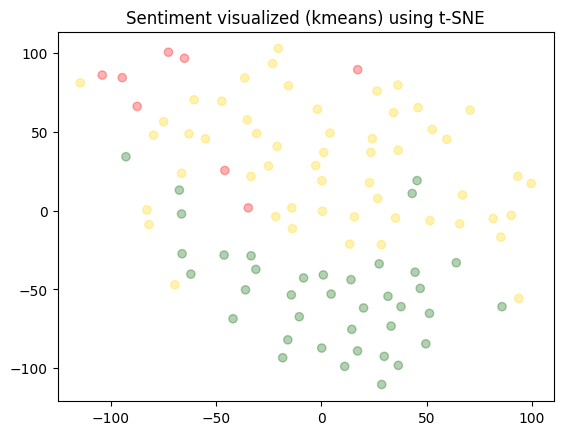

In [111]:
# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=20, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(X_train)
print("vis_dims", vis_dims.shape)

colors = ["red",  "gold", "darkgreen"]
x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]
color_indices = df["kmeans"].values - 1

colormap = matplotlib.colors.ListedColormap(colors)
plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Sentiment visualized (kmeans) using t-SNE")

## Cosine Similarity

In [131]:
def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [132]:
df.head()

,Text,Sentiment,tiktoken_embedding,st_embedding,tiktoken_count,st_count,word_count,kmeans
0,Trying out a new dessert recipe. ...,Positive,"[88976, 842, 261, 620, 47296, 14420, 13, 699]","[-0.014330666, -0.049130578, 0.0030075375, 0.0...",8,384,6,0
1,"Playfully dancing in the rain of laughter, a ...",Playful,"[9103, 5203, 38157, 306, 290, 13873, 328, 6734...","[0.015664198, -0.0048338617, 0.05227115, 0.013...",26,384,18,1
2,"Exploring the ancient ruins of Angkor Wat, eac...",Exploration,"[24704, 7443, 290, 21574, 76738, 328, 5775, 23...","[0.018491017, 0.054280628, 0.06413508, 0.05055...",20,384,14,1
3,"Overwhelmed by the cacophony of expectations,...",Overwhelmed,"[7931, 163185, 3217, 656, 290, 80188, 6502, 44...","[0.0034730374, 0.038468692, 0.030071173, 0.033...",26,384,18,2
4,Surrounded by the vibrant colors of a flower g...,Nature's Beauty,"[14477, 62633, 656, 290, 35180, 10803, 328, 26...","[0.017445965, 0.07143598, 0.0415588, 0.0294761...",30,384,22,1


In [135]:
# Get embeddings for labels
pos_encode = model.encode("Positive")
neutral_encode = model.encode("Neutral")
neg_encode = model.encode("Negative")

label_embeddings = [neg_encode, neutral_encode, pos_encode]
print(pos_encode.shape)

(384,)


In [136]:
def label_score(review_embedding, label_embeddings):
    result = -1
    highest = -np.inf
    for idx, each_label_encode in enumerate(label_embeddings):
        cs = cosine_similarity(review_embedding, each_label_encode)
        if cs > highest:
            highest = cs
            result = idx
    return result
df["cs_label"] = df["st_embedding"].apply(lambda x: label_score(x, label_embeddings))
df.to_pickle(embedding_file_name)

In [137]:

with pd.option_context('display.max_colwidth', None):
    display(df.loc[df["cs_label"] == 0, ["Text", "Sentiment", "cs_label"]].sample(3))
    display(df.loc[df["cs_label"] == 1, ["Text", "Sentiment", "cs_label"]].sample(3))
    display(df.loc[df["cs_label"] == 2, ["Text", "Sentiment", "cs_label"]].sample(3))

,Text,Sentiment,cs_label
62,Regret over missed opportunities haunts my thoughts.,Regret,0
28,"Haunted by regrets, the ghost of the past lingers relentlessly.",Regret,0
35,Experiencing cyberbullying. Hateful messages online are disheartening.,Hate,0


,Text,Sentiment,cs_label
98,Lost my headphones again. How do they vanish into thin air? #HeadphoneMystery #TeenLife,Frustration,1
26,Contentment envelops as the aroma of freshly baked bread fills the air.,Contentment,1
95,"Staring at the clock in class, waiting for the bell to ring like it's the most exciting event of the day. #ClassCountdown #TeenLife",Surprise,1


,Text,Sentiment,cs_label
90,"Cheering for the underdog in the basketball finals, the crowd erupts in applause as the team defies odds to claim the championship title.",Triumph,2
89,"Bathed in the glow of inspiration, a creative phoenix rising from the ashes of ordinary thoughts to explore new realms.",Inspired,2
60,"Reconnecting with old friends over a cup of tea. Friendship, the true essence of companionship. #OldFriends #Companionship",Contentment,2


# Test

In [8]:
result = client.models.embed_content(
        model="gemini-embedding-exp-03-07",
        contents=["Positive", "Negative"],
        config=types.EmbedContentConfig(task_type="SEMANTIC_SIMILARITY") # config=types.EmbedContentConfig(output_dimensionality=10),
    )
print(result.embeddings)
print("Content Count",len(result.embeddings))
print("Dimension",len(result.embeddings[0].values))


[ContentEmbedding(values=[-0.017238064, -0.0014344413, 0.0037933104, -0.06576155, -0.0025636086, 0.0058854055, -0.014690596, 0.007513689, 0.00933989, 0.0077803596, 0.021390285, -0.005264437, -0.021999894, 0.038152054, 0.12186416, -0.011710201, 0.0027378926, -0.009539084, 0.03546982, -0.016194234, -0.0051113074, 0.0031743597, -0.00054970535, -0.015809478, 0.00363587, -0.00062827585, 0.038027026, 0.005293967, 0.02749136, 0.006787016, -0.006366862, 0.022761336, 0.025653888, 0.0039313985, 0.017237084, 0.0002500477, 0.033836663, 0.030902233, 0.0037691516, 0.02828022, 0.0024121965, 0.0064366874, 0.013874366, -0.00014998807, -0.0006619651, 0.0019364081, 0.0047829114, -0.008891752, 0.0061919647, 0.032951612, -0.002562836, -0.015665058, 0.004700806, -0.15108715, -0.005898811, -0.008448396, -0.029177595, 0.008863029, 0.011009324, 0.011559, -0.00943173, 0.04199942, -0.01716688, -0.022339348, -0.0092252325, -0.025849525, 0.029452464, -0.02212326, -0.016344344, -0.0052618994, -0.00049180526, -0.000